In [ ]:
import numpy as np
%tensorflow_version 1.x
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import pandas as pd
def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "utf-8",
       names = ["Sentence", "Intent"])
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (intent, unique_intent, sentences)

In [ ]:
intent, unique_intent, sentences = load_dataset("/content/bank.csv")

0    2in1_acoount_info
1    2in1_acoount_info
2    2in1_acoount_info
3    2in1_acoount_info
4    2in1_acoount_info
Name: Intent, dtype: object


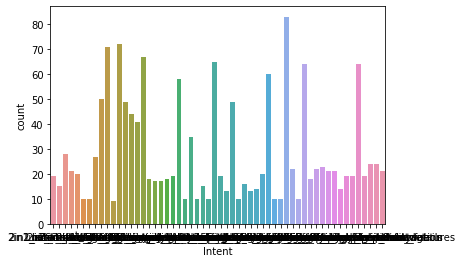

In [ ]:
print(intent[:5])
import seaborn as sns
sns.countplot(intent,label="Count")
plt.show()

In [ ]:
nltk.download("punkt")
def cleaning(sentences):
  words = [] 
  for s in sentences:
    w = word_tokenize(s)
    words.append([i for i in w])     
  return words  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  
print(len(sentences))

1567
[['நான்', '2in1', 'கணக்கில்', 'சேமிப்பது', 'எப்படி', '?'], ['2in1', 'கணக்கில்', 'நான்', 'சேமிப்பது', 'எப்படி', '?']]
1567


In [ ]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [ ]:
def max_length(words):
  return(len(max(words, key = len)))

In [ ]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 1141 and Maximum length = 22


In [ ]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [ ]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)

In [ ]:
padded_doc[:5]

array([[  3,  45,  62, 348,  11,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 45,  62,   3, 348,  11,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 11,   3,  45,  62, 348,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  11,  45,  62, 348,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 45,  62,   3, 587, 287,   2,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [ ]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (1567, 22)


In [ ]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [ ]:
output_tokenizer.word_index

{'2in1_acoount_info': 14,
 '2in1_atm_card': 43,
 '2in1_interest_receiving': 52,
 '2in1_min_balance': 47,
 '2in1_pass_book': 33,
 'account_currency': 1,
 'bank_statement_online': 46,
 'cancel_card': 15,
 'card_automatic_renewal': 37,
 'card_foreign_use': 22,
 'card_machine_repair': 5,
 'card_usage': 32,
 'change_details': 54,
 'cvv_use': 27,
 'debit_card_requirement': 38,
 'fcaispe_required_docs': 35,
 'foreign_account_lkr_withdrawal': 28,
 'foreign_currency_withdrawal': 50,
 'foreign_currency_withdrawal_currency': 44,
 'foreign_deposit_loan': 4,
 'get_lc_form': 9,
 'get_monthly_report': 30,
 'housing_loan_documents': 19,
 'housing_loan_purpose': 6,
 'interest_credit_info': 11,
 'internet_bank_loan_amount': 13,
 'joint_account_details': 49,
 'life_insurance_limit': 18,
 'loan_requirement': 56,
 'marriage_claim': 40,
 'new_card_reader_cost': 31,
 'new_saving_book': 10,
 'nrfc_account_opening': 23,
 'nrfc_info': 20,
 'precashing_foreign_fixed_deposit': 24,
 'repos_benefits': 41,
 'residen

In [ ]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [ ]:
encoded_output.shape

(1567, 1)

In [ ]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)

In [ ]:
output_one_hot.shape

(1567, 56)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, shuffle = True, test_size = 0.2)

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))
print("Shape of test_X = %s and test_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1002, 22) and train_Y = (1002, 56)
Shape of val_X = (314, 22) and val_Y = (314, 56)
Shape of test_X = (314, 22) and test_Y = (314, 56)


In [ ]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 300, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(256)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(56, activation = "softmax"))
  
  return model

In [ ]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 22, 300)           342300    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_7 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 56)                1848      
Total params: 1,501,300
Trainable params: 1,159,000
Non-trainable params: 342,300
_________________________________________________________________


In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 1002 samples, validate on 314 samples
Epoch 1/100
1002/1002 [==============================] - 10s 10ms/step - loss: 3.9901 - acc: 0.0569 - val_loss: 3.9352 - val_acc: 0.0860

Epoch 00001: val_loss improved from inf to 3.93522, saving model to model.h5
Epoch 2/100
1002/1002 [==============================] - 6s 6ms/step - loss: 3.8271 - acc: 0.0858 - val_loss: 3.7738 - val_acc: 0.0828

Epoch 00002: val_loss improved from 3.93522 to 3.77376, saving model to model.h5
Epoch 3/100
1002/1002 [==============================] - 6s 6ms/step - loss: 3.6154 - acc: 0.1277 - val_loss: 3.3568 - val_acc: 0.1306

Epoch 00003: val_loss improved from 3.77376 to 3.35677, saving model to model.h5
Epoch 4/100
1002/1002 [==============================] - 6s 6ms/step - loss: 3.2906 - acc: 0.1627 - val_loss: 3.1407 - val_acc: 0.1911

Epoch 00004: val_loss improved from 3.35677 to 3.14066, saving model to model.h5
Epoch 5/100
1002/1002 [==============================] - 6s 6ms/step - loss: 3.0806 - a

In [ ]:
 model = load_model("model.h5")

In [ ]:
def predictions(text):
  
  test_word = word_tokenize(text)
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model.predict_proba(x)
  
  
  return pred

In [ ]:
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [ ]:
text = "எனது கடன்அட்டையை நான் எவ்வகையில் ரத்து செய்வது?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['எனது', 'கடன்அட்டையை', 'நான்', 'எவ்வகையில்', 'ரத்து', 'செய்வது', '?']
cancel_card has confidence = 0.21924439
update_personal_details has confidence = 0.12690732
resident_foreign_account_info has confidence = 0.10434062
change_details has confidence = 0.089567006
SLBFE_info has confidence = 0.086473614
tikiri_gift_voucher_validity has confidence = 0.07680813
tikiri_gift_voucher_per_person has confidence = 0.07067075
2in1_acoount_info has confidence = 0.058321506
marriage_claim has confidence = 0.027570482
NRFC_info has confidence = 0.020597674
joint_account_details has confidence = 0.020425798
selan_sure_info has confidence = 0.019626223
get_lc_form has confidence = 0.010514114
2in1_min_balance has confidence = 0.010053273
seylan_tikiri_minimum_deposit has confidence = 0.008476666
tikiri_gift_voucher_redeem has confidence = 0.005339367
treasury_bond_advantage has confidence = 0.004835874
CVV_use has confidence = 0.0029916826
suspious_activity has confidence = 0.002957841
debit_card_re

In [ ]:

print(model.test_on_batch(test_X ,test_Y))
model.metrics_names

[0.36097506, 0.936255]


['loss', 'acc']